# Problem Description
In this project, the goal is to create a ML algorithm that can identify metastatic cancer from pathology scans. The metric that will be used to determine the performance of the model is the area under the ROC curve, which plots the true positive rate against hte false positive rate. The larger the area under the curve, the better the ML model is able to successfully predict if the patient has cancer.

To begin I will take a look a the general shape and format of the data.

In [ ]:
!pip install torch

In [2]:
from google.colab import files, drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import zipfile
import os
from PIL import Image
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [ ]:
'''
Steps:
1) Apply transforms of data
2) Initialize data with Dataset and DataLoader Classes
3) Create model
4) Train Model with typical training loop
5) Evaluate Model with AUC Score
'''

'\nSteps:\n1) Apply transforms of data\n2) Initialize data with Dataset and DataLoader Classes\n3) Create model\n4) Train Model with typical training loop\n5) Evaluate Model with AUC Score\n'

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%time
zip_file_path = r'/content/drive/MyDrive/Colab Notebooks/ML3 Week 3 Programming Assignment/Data/Data.zip'
extraction_folder = '/content/Data'

os.makedirs(extraction_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

CPU times: user 1min 23s, sys: 31.4 s, total: 1min 55s
Wall time: 3min 28s


In [5]:
# Setup the device if GPU support is supported
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the labels dataframe and define paths to the necessary directories
labels_df = pd.read_csv('/content/Data/train_labels.csv')
train_dir = 'Data/train'
test_dir = 'Data/test'

In [6]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
labels_df.describe(include='all')

,id,label
count,220025,220025.000000
unique,220025,NaN
top,f38a6374c348f90b587e046aac6079959adf3835,NaN
freq,1,NaN
mean,NaN,0.405031
std,NaN,0.490899
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


## Data Description
We can see from the above inspection of the data that we have 220025 images in the training data with a label column that defines whether the image contains cancer. Cancerous images are marked with a 1 and non-cancerous images are marked with 0.

# Exploratory Data Analysis
Here I take a look at how many images contain cancer vs how many images do not contain cancer. Then I display a few images for both cancerous and non-cancerous scans. I then perform a few transforms of the data so that I can work with it in pytorch to create a model.

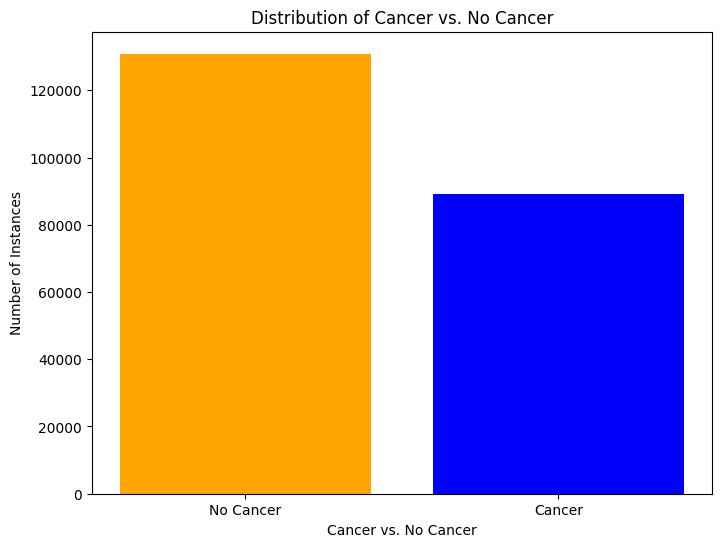

In [9]:
# Plot number of images with and without cancer

cancer_counts = labels_df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(cancer_counts.index, cancer_counts.values, color = ['orange', 'blue'])
plt.xlabel('Cancer vs. No Cancer')
plt.ylabel('Number of Instances')
plt.title('Distribution of Cancer vs. No Cancer')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])
plt.show()

Image size is 96 x 96


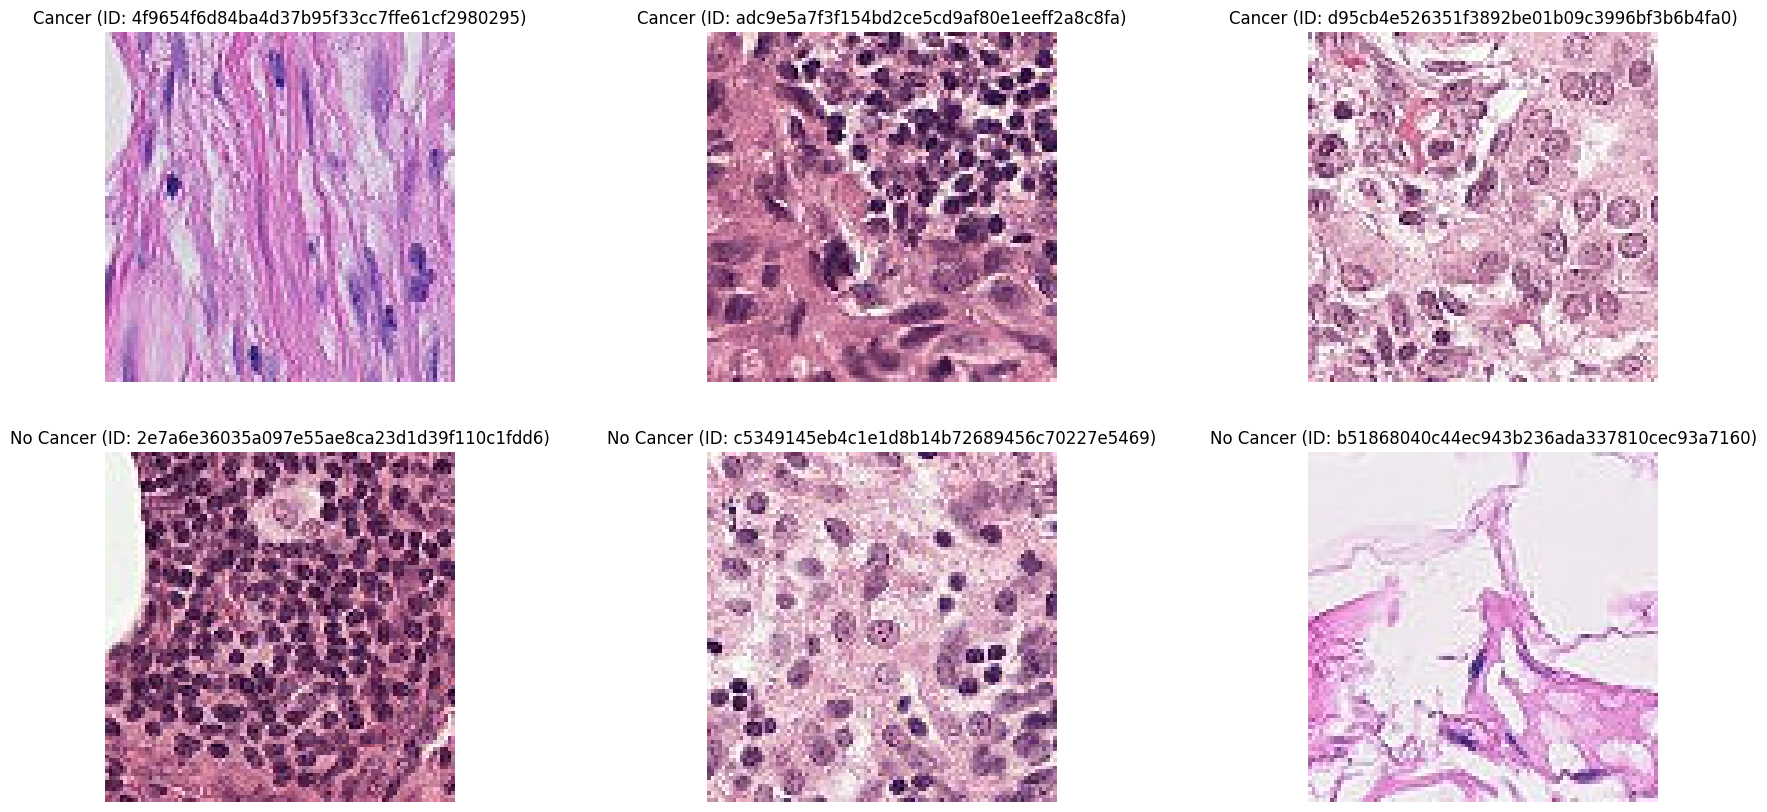

In [10]:
# Plot cancerous/non-cancerous image samples
cancer_images = labels_df[labels_df['label'] == 1]['id'].tolist()
non_cancer_images = labels_df[labels_df['label'] == 0]['id'].tolist()

cancer_samples = random.sample(cancer_images, 3)
non_cancer_samples = random.sample(non_cancer_images, 3)

img = Image.open(os.path.join(train_dir, cancer_samples[0] + '.tif'))
width, height = img.size
print(f'Image size is {width} x {height}')

plt.figure(figsize=(22,10))
for i, image_id in enumerate(cancer_samples):
  img_path = os.path.join(train_dir, f'{image_id}.tif')
  img = Image.open(img_path)

  plt.subplot(2, 3, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Cancer (ID: {image_id})')

for i, image_id in enumerate(non_cancer_samples):
  img_path = os.path.join(train_dir, f'{image_id}.tif')
  img = Image.open(img_path)

  plt.subplot(2, 3, i+4)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'No Cancer (ID: {image_id})')

In [11]:
# Create train and validation split
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

# Define Hyperparameters
learning_rate = 0.0025
num_epochs = 10
batch_size = 32

In [12]:
# Step 1: Define the Transforms of the Data
data_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Step 2: Define the Dataset
class CancerDataset(Dataset):
  def __init__(self, image_path, train=False, labels_df = None, map=None, transform=None):
    self.image_path = image_path
    self.map = map
    self.labels_df = labels_df
    self.train = train
    self.transform = transform
    self.image_files = os.listdir(self.image_path) if not self.train else None
    self.n_samples = len(self.image_files) if not self.train else labels_df.shape[0]
    if train:
      self.labels = self.labels_df.iloc[:, 1].values
    else:
      self.labels = [0]

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.image_path, self.labels_df.iloc[idx]['id']+'.tif')) if self.train else Image.open(os.path.join(self.image_path, self.image_files[idx]))
    image = image.crop((32,32,64,64))

    if self.train:
      label = self.labels[idx]
    else:
      label = self.labels[0]

    if self.transform:
      image = self.transform(image)

    return image, label

In [14]:
# Step 2 (cont): Initialize dataset and dataloader
dataset_tr = CancerDataset(train_dir, train=True, labels_df=train_df, transform=data_transforms)
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True, num_workers = 2)

dataset_val = CancerDataset(train_dir, train=True, labels_df=val_df, transform=data_transforms)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers = 2)

dataset_test = CancerDataset(test_dir, transform=data_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers = 2)

# Test if dataset is correctly configured
first_data = dataset_tr[0]
feature, label = first_data
print(f'Feature: {feature}')
print(f'Label: {label}')
print(f'Fetaure batch shape: {feature.size()}')

first_data = dataset_val[0]
feature, label = first_data
print(f'Feature: {feature}')
print(f'Label: {label}')
print(f'Fetaure batch shape: {feature.size()}')

first_data = dataset_test[0]
feature, label = first_data
print(f'Feature: {feature}')
print(f'Label: {label}')
print(f'Fetaure batch shape: {feature.size()}')

Feature: tensor([[[-0.7650, -0.6281, -1.0562,  ...,  2.0605,  2.2489,  1.5982],
         [ 0.1426, -0.4911, -0.8335,  ...,  2.2489,  1.9235,  1.9749],
         [ 0.0569, -0.7822,  0.1426,  ...,  1.4440,  1.8550,  2.0777],
         ...,
         [ 1.5297,  1.4954,  0.1426,  ...,  0.6392,  1.2557,  0.7591],
         [ 1.0844,  0.3652, -0.3541,  ...,  1.4098,  1.9920,  2.2489],
         [ 0.7419,  0.0912, -0.1143,  ...,  1.1872,  2.1975,  2.0777]],

        [[-1.5455, -1.3354, -1.6506,  ...,  1.8333,  2.0609,  1.3782],
         [-0.4951, -1.1253, -1.4230,  ...,  2.0959,  1.7108,  1.7808],
         [-0.4251, -1.3354, -0.4251,  ...,  1.3431,  1.7108,  1.9034],
         ...,
         [ 1.2906,  1.1856, -0.2850,  ...,  0.0826,  0.8179,  0.3627],
         [ 0.8004, -0.0224, -0.8803,  ...,  1.0455,  1.7633,  2.1660],
         [ 0.4153, -0.3200, -0.6702,  ...,  0.9230,  2.1310,  2.0609]],

        [[ 0.3393,  0.5311,  0.0779,  ...,  2.5354,  2.5877,  1.8208],
         [ 1.2805,  0.6705,  0.3393,

# Model Architecture
Here I create a simplistic model similar to the VGGNet architecture. I define two convolutional layers with Relu activation functions applied after the convolution and then a pooling operation applied. After the two convolutional layers, I define 3 dense layers. Two layers are activated via Relu functions, and the last layer has a sigmoid function applied to it to determine the probability of a scan that contains cancer cells.

I use the Adam optimizer, which is an improved Stochastic Gradient Desccent optimization technique and the loss function I used is binary cross entropy loss, which is suitable for binary classification problems. In order for the filter weights to be thoroughly refined via Adam optimization, I trained the model over 10 epochs with a batch size of 32.

In [15]:
# Step 3: Define Model
class ConvNN(nn.Module):
  def __init__(self):
    super(ConvNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.fc1 = nn.Linear(6*6*32, 100)
    self.fc2 = nn.Linear(100, 25)
    self.fc3 = nn.Linear(25, 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 6*6*32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))
    return x

model = ConvNN()
model = nn.DataParallel(model)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheudler = ReduceLROnPlateau(optimizer, patience=2)

In [16]:
# Step 4: Define the typical training loop
n_steps = len(dataloader_tr)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(dataloader_tr):
    images = images.to(device)
    labels = labels.to(device)

    # Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1).float())

    # Backprop and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 2 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_steps}], Loss: {loss.item():.4f}')

Streaming output truncated to the last 5000 lines.
Epoch [9/10], Step [1002/5501], Loss: 0.3499
Epoch [9/10], Step [1004/5501], Loss: 0.3915
Epoch [9/10], Step [1006/5501], Loss: 0.4015
Epoch [9/10], Step [1008/5501], Loss: 0.3829
Epoch [9/10], Step [1010/5501], Loss: 0.3716
Epoch [9/10], Step [1012/5501], Loss: 0.2773
Epoch [9/10], Step [1014/5501], Loss: 0.4288
Epoch [9/10], Step [1016/5501], Loss: 0.4514
Epoch [9/10], Step [1018/5501], Loss: 0.3255
Epoch [9/10], Step [1020/5501], Loss: 0.2640
Epoch [9/10], Step [1022/5501], Loss: 0.3661
Epoch [9/10], Step [1024/5501], Loss: 0.5401
Epoch [9/10], Step [1026/5501], Loss: 0.4451
Epoch [9/10], Step [1028/5501], Loss: 0.3871
Epoch [9/10], Step [1030/5501], Loss: 0.2813
Epoch [9/10], Step [1032/5501], Loss: 0.3113
Epoch [9/10], Step [1034/5501], Loss: 0.3900
Epoch [9/10], Step [1036/5501], Loss: 0.2278
Epoch [9/10], Step [1038/5501], Loss: 0.2598
Epoch [9/10], Step [1040/5501], Loss: 0.3924
Epoch [9/10], Step [1042/5501], Loss: 0.2453
Epoc

In [17]:
# Step 5 Evaluate Model
correct = 0
total = 0
loss_total = 0
model.eval

with torch.no_grad():
  for images, labels in dataloader_val:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    total += labels.size(0)
    correct += (outputs.round() == labels.unsqueeze(1).float()).sum().item()

    loss = criterion(outputs, labels.unsqueeze(1).float())
    loss_total += loss.item()

print(f'Accuracy of the model on the validation set: {100 * correct / total} %, Average Loss: {loss_total/len(dataloader_val)}')

Accuracy of the model on the validation set: 82.54062038404727 %, Average Loss: 0.4003698744399603


## Intermediate results
After a brief analysis on the evaluation data, the model was approximately 82.5% accurate on unseen data after training. This gives me confidence that my model will perform well on the test data, therefore, I will move on to evaluating my model on the test data and submit my results to Kaggle.

In [18]:
# Create testing loop
model.eval()
predictions = []
with torch.no_grad():
  for images, _ in dataloader_test:
    images = images.to(device)
    outputs = model(images)

    probabilities = outputs.detach().cpu().numpy().flatten()
    predictions.extend(probabilities)

In [22]:
submission_df = pd.DataFrame({'id': os.listdir(test_dir), 'label': predictions})
submission_df['id'] = submission_df['id'].str.split('.').str[0]
submission = submission_df.to_csv('submission.csv', index=False)

print(submission_df.tail())

                                             id     label
57453  a2c16d19df031a9597257a59b79e66515dca6084  0.009142
57454  b56a553666fdce7e134c7216b96f5b2e36bd0a7c  0.634575
57455  568bddc850b8f32de6af778303e030289e9e1036  0.866083
57456  4b75b1e92982993ef812e13795491cc989b8d320  0.596588
57457  b2101b405d0efe2edeb77317da9971c76b26ffae  0.079020


# Results and Analysis
Below is a table that shows the distribution of probabilities to see how sharply the model was able to distinguish between scans containing cancer and scans without cancer.

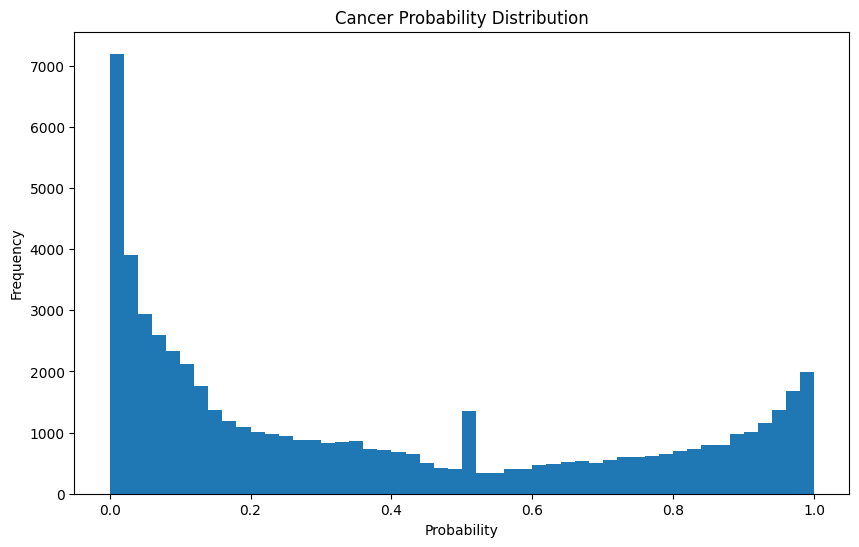

In [23]:
# Plot probability disribution
plt.figure(figsize=(10,6))
plt.hist(predictions, bins = 50)
plt.title('Cancer Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')

plt.show()

# Conclusion
As can be seen from the above figure, the model was highly confident of images that did not have cancer, which is displayed by having high frequency of near-zero probabilities, however, the more you move to the right, the less confident the model was to indicate that the image actually had cancer. In addition, there were many instances of the model being unsure if the image contained cancer or not, with the significant frequency of ~0.5 probabilities.

Potential ways to strengthen the model's predictions could be to apply batch normalization and dropouts to the inputs of every layer. This could significantly improve the model's performance.